In [1]:
from textwrap import indent

from IPython.display import Javascript

from liblet import ANTLR, AnnotatedTreeWalker, Tree, pyast2tree, side_by_side

from operator import add, mul, truediv, sub



from fractions import Fraction


In [127]:
ArithmeticExpression = ANTLR(r"""
grammar arithmetic;
ignoblebug: expression;

file_ : expression EOF;



expression                                               // TODO: parentesizzazione semplice efficiente
   : (PLUS | MINUS)? (INTEGER|RATIONAL)                  # atomExpression
   | <assoc=right>expression POW expression              # powExpression
   | expression  FRACT  expression                       # FractExpression
   | (PLUS | MINUS) expression                           # unaryExpression
   | expression  (TIMES | DIV)  expression               # divProdExpression
   | expression  (PLUS | MINUS) expression               # addSubExpression
   | GRAPH_L_PAREN expression GRAPH_R_PAREN              # blockExpression
   | SUBEXP_L_PAREN expression SUBEXP_R_PAREN            # subExpression
   ;


INTEGER   
   : NUMBER 
   ;
   
RATIONAL
    : NUMBER FRACT NUMBER
    ;


   
NUMBER
   : ('0' .. '9') + ('.' ('0' .. '9') +)?
   ;   
   
GRAPH_L_PAREN : '(' ;
GRAPH_R_PAREN : ')' ;
SUBEXP_L_PAREN : '<' ;
SUBEXP_R_PAREN : '>' ;
PLUS   : '+' ;
MINUS  : '-' ;
TIMES  : 'x' ;
DIV    : ':' ;
POINT  : '.' ;
POW    : '^' ;
FRACT  : '/' ;

WS
   : [ \r\n\t] + -> skip
   ;
   

""")

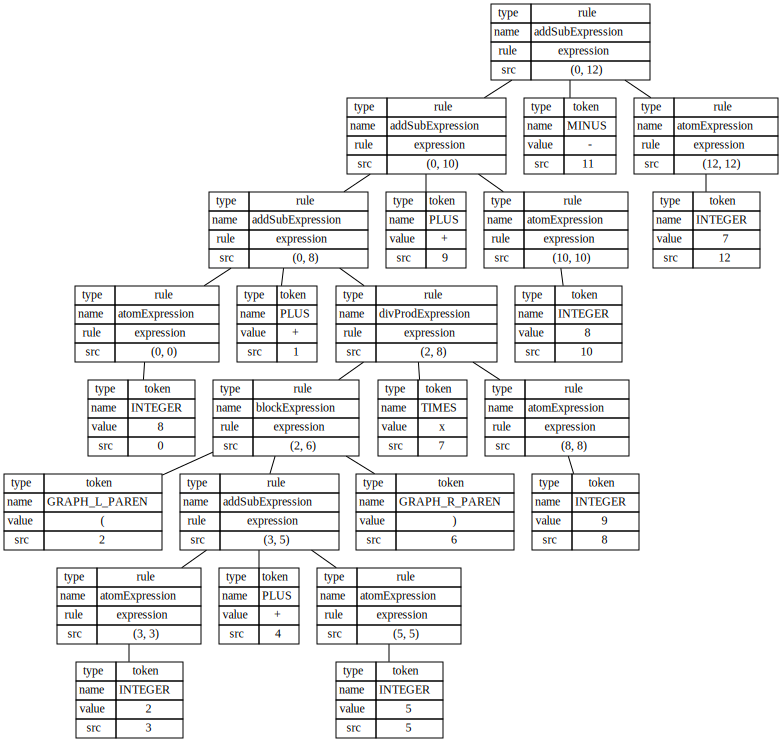

In [133]:
expr = """
1 + (2 x ((3 + 4 : 2) + 5) x 6) - (7 + (1 + 8) : 3) x (9 : (2 + 1) + 2)
"""

expr = '8 + (2+5) x 9 + 8 - 7'


ptree = ArithmeticExpression.tree(expr, 'expression')
ptree

4

In [134]:
arith2ast = AnnotatedTreeWalker('name')


PRIORITY = {
    'blockExpression' : 6,
    'fractExpression' : 5,
    'powExpression' : 4,
    'unaryExpression' : 3,
    'divProdExpression' : 2,
    'addSubExpression' : 1
}

@arith2ast.register
def RATIONAL(visit, ptree):
    return Fraction(ptree.root['value'])

@arith2ast.register
def INTEGER(visit, ptree):
    return int(ptree.root['value'])


@arith2ast.register
def atomExpression(visit, ptree):
    child = ptree.children[0]
    #return Tree({'type': child.root['name'].lower(), 'value': int(child.root['value'])}, []), 0
    return Tree({'type': 'atomExpression', 'value': visit(child)}, []), 0

@arith2ast.register
def addSubExpression(visit, ptree):
    left, op, right = ptree.children
    left, left_depth = visit(left)
    right, right_depth = visit(right)
    
    priority = max(left_depth, right_depth, PRIORITY['addSubExpression'])
    return Tree({'type': 'addSubExpression', 'op': op.root['value'], 'priority' : priority}, [left, right]), priority


@arith2ast.register
def divProdExpression(visit, ptree):
    left, op, right = ptree.children    
    left, left_depth = visit(left)
    right, right_depth = visit(right)
    
    priority = max(left_depth, right_depth, PRIORITY['divProdExpression'])    
    return Tree({'type': 'divProdExpression', 'op': op.root['value'], 'priority' : priority}, [left, right]), priority



@arith2ast.register
def divProdExpression(visit, ptree):
    left, op, right = ptree.children
    
    left, left_depth = visit(left)
    right, right_depth = visit(right)
    
    priority = max(left_depth, right_depth) 
    
    return Tree({'type': 'divProdExpression', 'op': op.root['value'], 'priority' : PRIORITY['divProdExpression']}, [left, right]), priority


@arith2ast.register
def powExpression(visit, ptree):
    left, _, right = ptree.children    
    left, left_depth = visit(left)
    right, right_depth = visit(right)
    
    priority = max(left_depth, right_depth)
    return Tree({'type': 'powExpression', 'priority' : PRIORITY['powExpression']}, [left, right]), priority


@arith2ast.register
def fractExpression(visit, ptree):
    left, _, right = ptree.children    
    left, left_depth = visit(left)
    right, right_depth = visit(right)
    
    priority = max(left_depth, right_depth)
    return Tree({'type': 'fractExpression', 'priority' : PRIORITY['fractExpression']}, [left, right]), priority


@arith2ast.register
def blockExpression(visit, ptree):
    _, subexpr, _ = ptree.children
    subexpr, priority = visit(subexpr)
    
    return Tree({'type': 'blockExpression', 'priority' : PRIORITY['blockExpression'] + priority}, [subexpr]), root_depth
    #depth = depth + 1
    #subexpr.root['depth'] = depth
    #return subexpr, depth
    

@arith2ast.register
def subExpression(visit, ptree):
    _, subexpr, _ = ptree.children
    return visit(subexpr)
    #depth = depth + 1
    #subexpr.root['depth'] = depth
    #return subexpr, depth
    



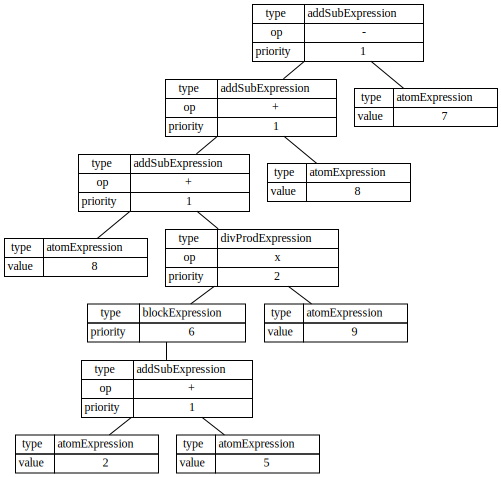

In [135]:
ast, _ = arith2ast(ptree)
ast

In [115]:
def src2ast(source):
    ast, _ = arith2ast(ArithmeticExpression.tree(source, 'expression'))
    return ast

Fraction(6, 3) + 1

Fraction(3, 1)

In [116]:
atw_eval = AnnotatedTreeWalker('type')

ARITH_OP = {
    '+' : add,
    '-' : sub,
    'x' : mul,
    ':' : Fraction,
    '/' : Fraction
}



def findPriorityNode(ast):
    max_depth = -1
    max_priority = -1
    res = -1
    for i, child in enumerate(ast.children):
        if 'depth' in child.root:
            child_priority = PRIORITY[child.root['type']]
            child_depth = child.root['depth']
            if child_depth > max_depth or (max_depth == 0 and child_priority > max_priority):
                res = i
                max_depth = child_depth
                max_priority = child_priority
    return res

@atw_eval.register
def atomExpression(visit, ast):
    #child = ast.children[0]
    #return Tree({'type': child.root['name'].lower(), 'value': child.root['value']}, []), False
    return Tree({'type': ast.root['type'], 'value': ast.root['value']}, []), 0

@atw_eval.register
def addSubExpression(visit, ast):
    max_depth_index = findPriorityNode(ast)
    op = ast.root['op']
    
    if max_depth_index == -1:  
        left, right = ast.children
        left, _ = visit(left)
        right, _ = visit(right)

        return Tree({'type': 'atomExpression', 'value': ARITH_OP[op](left.root['value'], right.root['value'])}, []), 0
    
    children = ast.children.copy()
    children[max_depth_index], depth = visit(ast.children[max_depth_index])
    
    depth = max([child.root['depth'] for child in children if 'depth' in child.root] + [0])
    
    res = Tree({'type': 'addSubExpression', 'op': op, 'depth' : depth}, children)
    
    if findPriorityNode(res) == -1 and ast.children[max_depth_index].root['type'] == 'addSubExpression':
        return visit(res)
    return res, depth
    
    
    

@atw_eval.register
def divProdExpression(visit, ast):
    max_depth_index = findPriorityNode(ast)
    op = ast.root['op']
    left, right = ast.children
    
    if ast.root['op'] == '/' and 'depth' not in left.root and 'depth' not in  right.root:
        return Tree({'type': 'atomExpression', 'value': Fraction(left.root['value'], right.root['value'])}, []), 0
        
    
    if max_depth_index == -1:  
        left, _ = visit(left)
        right, _ = visit(right)

        return Tree({'type': 'atomExpression', 'value': ARITH_OP[op](left.root['value'], right.root['value'])}, []), 0
    
    children = ast.children.copy()
    children[max_depth_index], depth = visit(ast.children[max_depth_index])
    
    depth = max([child.root['depth'] for child in children if 'depth' in child.root] + [0])
    
    res = Tree({'type': 'divProdExpression', 'op': op, 'depth' : depth}, children)
    
    if findPriorityNode(res) == -1 and ast.children[max_depth_index].root['type'] == 'addSubExpression':
        return visit(res)
    return res, depth   


@atw_eval.register
def powExpression(visit, ast):
    max_depth_index = findPriorityNode(ast)
    left, right = ast.children
    
    if max_depth_index == -1:  
        left, _ = visit(left)
        right, _ = visit(right)

        return Tree({'type': 'atomExpression', 'value': pow(left.root['value'], right.root['value'])}, []), 0
    
    children = ast.children.copy()
    children[max_depth_index], depth = visit(ast.children[max_depth_index])
    
    depth = max([child.root['depth'] for child in children if 'depth' in child.root] + [0])
    
    res = Tree({'type': 'powExpression', 'depth' : depth}, children)

    return res, depth

@atw_eval.register
def blockExpression(visit, ast):
    child, depth = visit(ast.children[0])
    if 'depth' not in child.root:
        return child, depth
    
    #ast.root['depth'] = depth + 1
    root_depth = depth + 1
    return Tree({'type': 'blockExpression', 'depth' : root_depth}, [child]), root_depth

    #depth = depth + 1
    #subexpr.root['depth'] = depth
    #return subexpr, depth


In [117]:
def step(ast):
    res, _ = atw_eval(ast)
    return res

1

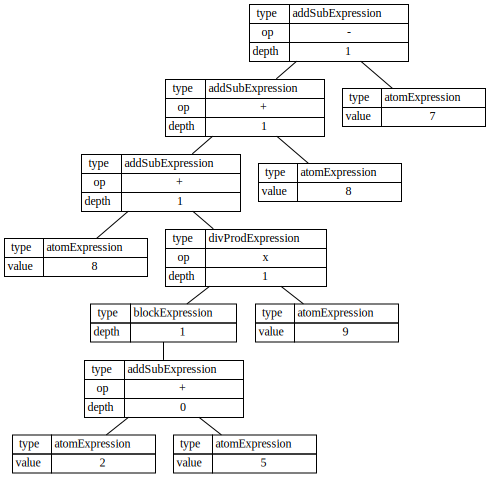

----------------------------------------------------------------------------------------------------


2

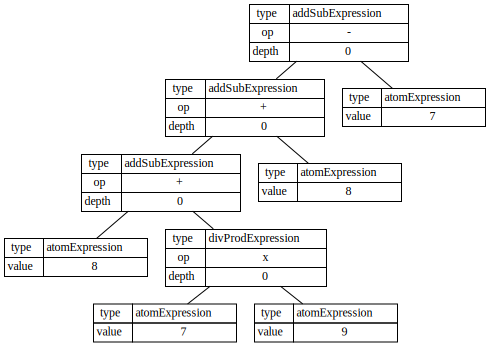

----------------------------------------------------------------------------------------------------


3

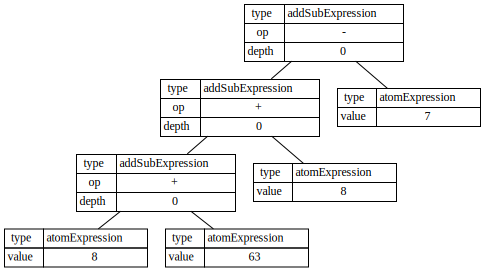

----------------------------------------------------------------------------------------------------


3

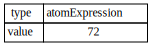

In [124]:
expr = '1 x 8 x 7 x (8 + 7) + (9 x 7 + 8 - (3 + 2+ 3))) - (8 + 9 + 8 + (4))'
ex1 = '1 + (2 x ((3 + 4 : 2) + 5) x 6) - (7 + (1 + 8) : 3) x(9 : (2 + 1) +2)'
ex2 = '(2+3)/4/(5+6)/7'
ex3 = '2^(3+4^5:2^7)'
ex4 = '3 + 13 x (1 + 3)/(2^(1+4) - 6)'
ex5 = '3 / < 4 + 2 > + 2 x ( 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > ) - < 2 x ( 5 x ( 3 + 4 ) + 5 ) - 1 > / 6'
expr = '8 + (2+5) x 9 + 8 - 7'

ast = src2ast(expr)
#step(ast)
#step(ast)
count = 0
while ast.children != [] :
    count += 1
    display(count, ast)
    ast = step(ast)
    print('-' * 100)

display(count, ast)
